## SSD (物体検出)
SSDについてのわかりやすい記事  
https://avinton.com/blog/2018/03/single-shot-multibox-detector-explained1/  


In [2]:
import os, glob, cv2, random
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data as data

# 画像データ、アノテーションデータへのファイルパスのリストを作成する

In [3]:
def make_datapath_list(rootpath):
    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = os.path.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = os.path.join(rootpath, 'Annotations', '%s.xml')

    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = os.path.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = os.path.join(rootpath + 'ImageSets/Main/val.txt')
    
    train_img_list = list()
    train_anno_list = list()
    
    for line in open(train_id_names):
        file_id = line.strip()
        img_path = imgpath_template % file_id
        anno_path = annopath_template % file_id
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)
        
    val_img_list = list()
    val_anno_list = list()
    
    for line in open(val_id_names):
        file_id = line.strip()
        img_path = imgpath_template % file_id
        anno_path = annopath_template % file_id
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)
        
    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [4]:
rootpath = "./data/VOCdevkit/VOC2012/"
imgpath_template = os.path.join(rootpath, 'JPEGImages', '%s.jpg')
train_id_names = os.path.join(rootpath + 'ImageSets/Main/train.txt')
for i in open(train_id_names):
    print(imgpath_template % i.strip())

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000015.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000019.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000023.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000028.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000033.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000036.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000037.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000041.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000045.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000053.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000060.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000066.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000070.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000074.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000085.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000089.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000093.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2008_000095.jpg
./data/VOCde

./data/VOCdevkit/VOC2012/JPEGImages/2010_002301.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002309.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002312.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002318.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002320.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002327.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002333.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002338.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002346.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002349.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002353.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002356.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002363.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002364.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002368.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002369.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002371.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002374.jpg
./data/VOCdevkit/VOC2012/JPEGImages/2010_002378.jpg
./data/VOCde

In [5]:
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)
train_img_list[:5],train_anno_list[:5], 

(['./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg',
  './data/VOCdevkit/VOC2012/JPEGImages/2008_000015.jpg',
  './data/VOCdevkit/VOC2012/JPEGImages/2008_000019.jpg',
  './data/VOCdevkit/VOC2012/JPEGImages/2008_000023.jpg',
  './data/VOCdevkit/VOC2012/JPEGImages/2008_000028.jpg'],
 ['./data/VOCdevkit/VOC2012/Annotations/2008_000008.xml',
  './data/VOCdevkit/VOC2012/Annotations/2008_000015.xml',
  './data/VOCdevkit/VOC2012/Annotations/2008_000019.xml',
  './data/VOCdevkit/VOC2012/Annotations/2008_000023.xml',
  './data/VOCdevkit/VOC2012/Annotations/2008_000028.xml'])

# xml形式のアノテーションデータをリストに変換する

In [10]:
class Anno_xml2list:
    """
    1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

    Attributes
    ----------
    classes : リスト
        VOCのクラス名を格納したリスト
    """   
    
    def __init__(self, classes):
        self.classes = classes
        
    def __call__(self, xml_path, width, height):
        """
        1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

        Parameters
        ----------
        xml_path : str
            xmlファイルへのパス。
        width : int
            対象画像の幅。
        height : int
            対象画像の高さ。

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            物体のアノテーションデータを格納したリスト。画像内に存在する物体数分のだけ要素を持つ。
        """
        
        ret = []
        
        xml = ET.parse(xml_path).getroot()
        
        # 画像内にある物体（object）の数だけループする
        for obj in xml.iter('object'):
            
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue
            
            # 1つの物体に対するアノテーションを格納するリスト
            bndbox = []
            
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')
            
            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            
            for pt in pts:
                # VOCは原点が(1,1)なので1を引き算して（0, 0）に
                cur_pixel = int(bbox.find(pt).text) - 1
                
                # 幅、高さで規格化
                if pt == 'xmin' or pt=='xmax':
                    cur_pixel /= width
                else:
                    cur_pixel /= height
                
                bndbox.append(cur_pixel)
            
            #アノテーションのクラス名のindexを取得して追加
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)
            
            ret += [bndbox]
            
        return np.array(ret)

In [31]:
def xml2df(xml_data):
    root = ET.XML(xml_data) # element tree
    all_records = []
    for i, child in enumerate(root):
        record = {}
        for subchild in child:
            record[subchild.tag] = subchild.text
        all_records.append(record)
    df = pd.DataFrame(all_records)
    return df

# load XML to dataframe (gotta be small)
xml_data = open(train_anno_list[0]).read()
df = xml2df(xml_data)
df

,database,annotation,image,width,height,depth,name,pose,truncated,occluded,bndbox,difficult
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,The VOC2008 Database,PASCAL VOC2008,flickr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,500,442,3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,horse,Left,0,1,\n\t\t\t,0
6,NaN,NaN,NaN,NaN,NaN,NaN,person,Unspecified,1,0,\n\t\t\t,0


In [11]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)
height, width, channels = img.shape

transform_anno(train_anno_list[0], width, height)

array([[ 0.104     ,  0.19457014,  0.94      ,  0.9479638 , 12.        ],
       [ 0.314     ,  0.09728507,  0.576     ,  0.37556561, 14.        ]])

horse person


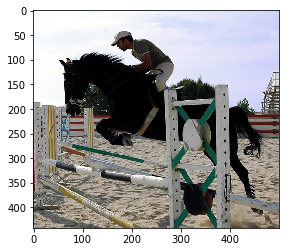

In [18]:
img = plt.imread(train_img_list[0])
plt.imshow(img)

print(voc_classes[12], voc_classes[14])

# 画像とアノテーションの前処理を行うクラスDataTransformを作成する

In [22]:
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans

class DataTransform:
    """
    画像とアノテーションの前処理クラス。訓練と推論で異なる動作をする。
    画像のサイズを300x300にする。
    学習時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (B, G, R)
        各色チャネルの平均値。
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train' : Compose([
                ConvertFromInts(),  # intをfloat32に変換
                ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す   ---argumentation
                PhotometricDistort(),  # 画像の色調などをランダムに変化       ---argumentation
                Expand(color_mean),  # 画像のキャンバスを広げる                  ---argumentation
                RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す  ---argumentation
                RandomMirror(),  # 画像を反転させる                                        ---argumentation
                ToPercentCoords(),  # アノテーションデータを0-1に規格化
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ]),
            'val' : Compose([
                ConvertFromInts(),  # intをfloatに変換
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ])
        }
    
    def __call__(self, img, phase, boxes, labels):
        return self.data_transform[phase](img, boxes, labels)

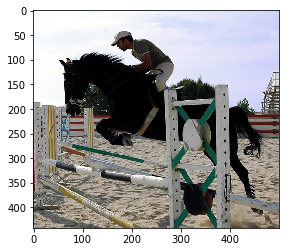

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


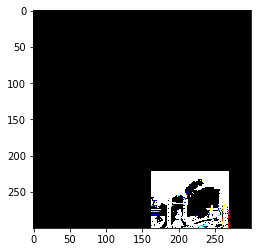

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


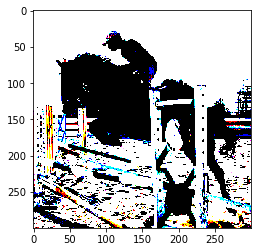

In [23]:
# 1. 画像読み込み
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# 2. アノテーションをリストに
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)

# 5. train画像の表示
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val画像の表示
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

In [35]:
print(labels.shape)
print(np.expand_dims(labels, axis=1).shape)
print(boxes.shape)
np.hstack((boxes,np.expand_dims(labels, axis=1)))

(2,)
(2, 1)
(2, 4)


array([[ 52.,  86., 470., 419.,  12.],
       [157.,  43., 288., 166.,  14.]])

# Datasetを作成する
画像を入力すると、変換後の画像と、正解ラベルを返してくれるクラス

In [56]:
class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    transform_anno : object
        xmlのアノテーションをリストに変換するインスタンス
    """
    
    def __init__(self, img_list, anno_list, phase, transform=None, transform_anno=None):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transoform = transform
        self.transoform_anno = transform_anno
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        '''
        前処理をした画像のテンソル形式のデータとアノテーションを取得
        '''
        img, gt, h, w = self.pull_item(index)
        return img, gt
        
    def pull_item(self, index):
        '''前処理をした画像のテンソル形式のデータ、アノテーション、画像の高さ、幅を取得する'''
            
        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path) # [高さ][幅][色BGR]
        height, width, channels = img.shape

        # 2. xml形式のアノテーション情報をリストに
        anno_file_path = self.anno_list[index]
        anno_list = self.transoform_anno(anno_file_path, width, height)

        # 3. 前処理を実施
        img, boxes, labels = self.transoform(img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 色チャネルの順番がBGRになっているので、RGBに順番変更
        # さらに（高さ、幅、色チャネル）の順を（色チャネル、高さ、幅）に変換
        # torch.from_numpyでnumpy型をtorchテンソルに変換
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBoxとラベルをセットにしたnp.arrayを作成、変数名「gt」はground truth（答え）の略称
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width

In [61]:
# 動作確認
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


val_dataset.__getitem__(1)

(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9082,  -13.2200,
             -9.4034],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9501,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2816,  -20.1750,   -5.5633,  ..., -104.9934, -111.8350,
           -119.0000],
          [ -20.4766,  -21.0000,  -12.6334,  ..., -107.1685, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0766,  -14.7250,
            -11.8534],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5016,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9501,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

# DataLoaderを作成する

In [62]:
def od_collate_fn(batch):
    """
    Datasetから取り出すアノテーションデータのサイズが画像ごとに異なります。
    画像内の物体数が2個であれば(2, 5)というサイズですが、3個であれば（3, 5）など変化します。
    この変化に対応したDataLoaderを作成するために、
    カスタイマイズした、collate_fnを作成します。
    collate_fnは、PyTorchでリストからmini-batchを作成する関数です。
    ミニバッチ分の画像が並んでいるリスト変数batchに、
    ミニバッチ番号を指定する次元を先頭に1つ追加して、リストの形を変形します。
    """
    
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])# sample[0] は画像img
        targets.append(torch.FloatTensor(sample[1]))# sample[1] はアノテーションgt
        
    # imgsはミニバッチサイズのリストになっています
    # リストの要素はtorch.Size([3, 300, 300])です。
    # このリストをtorch.Size([batch_num, 3, 300, 300])のテンソルに変換します
    imgs = torch.stack(imgs, dim=0)
    
        # targetsはアノテーションデータの正解であるgtのリストです。
    # リストのサイズはミニバッチサイズです。
    # リストtargetsの要素は [n, 5] となっています。
    # nは画像ごとに異なり、画像内にある物体の数となります。
    # 5は [xmin, ymin, xmax, ymax, class_index] です

    return imgs, targets

In [63]:
batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

dataloaders_dict = {'train' : train_dataloader, 'val' : val_dataloader}
batch_iterator = iter(dataloaders_dict['val'])
images, targets = next(batch_iterator)

print(images.size())  
print(len(targets))
print(targets[1].size())  # ミニバッチのサイズのリスト、各要素は[n, 5]、nは物体数

torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [64]:
print(train_dataset.__len__())
print(val_dataset.__len__())

5717
5823


# 2.4 ネットワークモデルの実装、2.5 順伝搬関数の実装

In [1]:
from math import sqrt
from itertools import product
import pandas as pd

import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

/home/nagae/.conda/envs/pytorch/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# vggモジュールを実装

In [2]:
def make_vgg():
    layers = []
    in_channels = 3
    
    # vggモジュールで使用する畳み込み層やマックスプーリングのチャネル数
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
           256, 'MC', 512, 512, 512, 'M', 512, 512, 512]
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
        
    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6, nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    
    return nn.ModuleList(layers)

vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(3, 512, kernel_size=(3, 3), st

# extrasモジュールを実装

In [3]:
def make_extras():
    layers = []
    in_channels = 1024
    
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]
    
    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=1, padding=1)]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=3, stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=1)]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=3, stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=1)]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=3)]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=1)]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=3)]
    
    return nn.ModuleList(layers)

extra_test = make_extras()
print(extra_test)

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


# locモジュールとconfモジュールを実装

In [5]:
def make_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):
    
    loc_layers = []
    conf_layers = []
    
    # VGGの22層目、conv4_3（source1）に対する畳み込み層
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0]*4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]*num_classes, kernel_size=3, padding=1)]
    
    # VGGの最終層（source2）に対する畳み込み層
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1]*4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1]*num_classes, kernel_size=3, padding=1)]
    
    # extraの（source3）に対する畳み込み層
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2]*4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]*num_classes, kernel_size=3, padding=1)]

    # extraの（source4）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3]*4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]*num_classes, kernel_size=3, padding=1)]

    # extraの（source5）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4]*4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]*num_classes, kernel_size=3, padding=1)]
    
    # extraの（source6）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5]*4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]*num_classes, kernel_size=3, padding=1)]
    
    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)

loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


# L2Norm層を実装

In [19]:
# convC4_3からの出力をscale=20のL2Normで正規化する層
class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__() # 親クラスのコンストラクタ実行
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale # 係数weightの初期値として設定する値
        self.reset_parameters()
        self.eps = 1e-10
        
    def reset_parameters(self):
        '''結合パラメータを大きさscaleの値にする初期化を実行'''
        init.constant_(self.weight, self.scale)
        
    def forward(self, x):
        '''38×38の特徴量に対して、512チャネルにわたって2乗和のルートを求めた
        38×38個の値を使用し、各特徴量を正規化してから係数をかけ算する層'''
        
        # 各チャネルにおける38×38個の特徴量のチャネル方向の2乗和を計算し、
        # さらにルートを求め、割り算して正規化する
        # normのテンソルサイズはtorch.Size([batch_num, 1, 38, 38])
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt() + self.eps
        x = torch.div(x, norm)
        
        # 係数をかける。係数はチャネルごとに1つで、512個の係数を持つ
        # self.weightのテンソルサイズはtorch.Size([512])なので
        # torch.Size([batch_num, 512, 38, 38])まで変形
        weights = self.weightg.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x
        
        return out

# デフォルトボックスを実装

In [9]:
class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()
        
        self.image_size = cfg['input_size']
        self.feature_maps = cfg['feature_maps']
        self.num_priors = len(cfg['feature_maps']) # sourceの個数=6
        self.steps = cfg['steps'] # [8, 16, …] DBoxのピクセルサイズ
        self.min_sizes = cfg['min_sizes']  # [30, 60, …] 小さい正方形のDBoxのピクセルサイズ
        self.max_sizes = cfg['max_sizes']  # [60, 111, …] 大きい正方形のDBoxのピクセルサイズ
        self.aspect_ratios = cfg['aspect_ratios']  # 長方形のDBoxのアスペクト比
        
    def make_dbox_list(self):
        mean = []
        
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):
                # 特徴量の画像サイズ
                # 300 / 'steps': [8, 16, 32, 64, 100, 300],
                f_k = self.image_size / self.steps[k]
                
                # DBoxの中心座標 x,y　ただし、0～1で規格化している
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k
                
                # アスペクト比1の小さいDBox [cx,cy, width, height]
                # 'min_sizes': [30, 60, 111, 162, 213, 264]
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]
                
                # アスペクト比1の大きいDBox [cx,cy, width, height]
                # 'max_sizes': [60, 111, 162, 213, 264, 315],
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]
                
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]
         
        # DBoxをテンソルに変換 torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)
        
        # DBoxが画像の外にはみ出るのを防ぐため、大きさを最小0、最大1にする
        output.clamp_(max=1, min=0)
        
        return output

In [11]:
# SSD300の設定
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

pd.DataFrame(dbox_list.numpy())

,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,0.502046,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


In [20]:
class SSD(nn.Module):
    def __init__(self, phase, cfg):
        super(SSD, self).__init__()
        
        self.phase =phase
        self.num_classes = cfg['num_classes']
        
        # SSDのネットワークを作る
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(cfg['num_classes'], cfg['bbox_aspect_num'])
        
        # DBox作成
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()
        
        # 推論時はクラス「Detect」を用意
        if phase == 'inference':
            self.detect = Detect()
            
ssd_test = SSD(phase='train', cfg=ssd_cfg)
ssd_test

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Tru

# 関数decodeを実装する

In [23]:
# オフセット情報を使い、DBoxをBBoxに変換する関数

def decode(loc, dbox_list):
    """
    オフセット情報を使い、DBoxをBBoxに変換する。

    Parameters
    ----------
    loc:  [8732,4]
        SSDモデルで推論するオフセット情報。
    dbox_list: [8732,4]
        DBoxの情報

    Returns
    -------
    boxes : [xmin, ymin, xmax, ymax]
        BBoxの情報
    """
        
    # DBoxは[cx, cy, width, height]で格納されている
    # locも[Δcx, Δcy, Δwidth, Δheight]で格納されている
    
    # オフセット情報からBBoxを求める
    boxes = torch.cat((
            dbox_list[:, :2] + loc[:, :2]*0.1*dbox_list[:, 2:],
            dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)
    # boxesのサイズはtorch.Size([8732, 4])
    
    # BBoxの座標情報を[cx, cy, width, height]から[xmin, ymin, xmax, ymax] に
    boxes[:, :2] -= boxes[:, 2:] / 2 # 座標(xmin,ymin)へ変換
    boxes[:, 2:] += boxes[:, :2] 
    
    return boxes

# Non-Maximum Suppressionを行う関数を実装する

In [32]:
def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    """
    Non-Maximum Suppressionを行う関数。
    boxesのうち被り過ぎ（overlap以上）のBBoxを削除する。

    Parameters
    ----------
    boxes : [確信度閾値（0.01）を超えたBBox数,4]
        BBox情報。
    scores :[確信度閾値（0.01）を超えたBBox数]
        confの情報

    Returns
    -------
    keep : リスト
        confの降順にnmsを通過したindexが格納
    count：int
        nmsを通過したBBoxの数
    """

    # returnのひな形を作成
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    
    # keep：torch.Size([確信度閾値を超えたBBox数])、要素は全部0
    
    # 各BBoxの面積areaを計算
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    
    # boxesをコピーする。後で、BBoxの被り度合いIOUの計算に使用する際のひな形として用意
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()    
    
    # socreを昇順に並び変える
    v, idx = scores.sort(0)
    
    # 上位top_k個（200個）のBBoxのindexを取り出す（200個存在しない場合もある）
    idx = idx[-top_k:]
    
    # idxの要素数が0でない限りループする
    while idx.numel() > 0:
        i = idx[-1]  # 現在のconf最大のindexをiに
        
        # keepの現在の最後にconf最大のindexを格納する
        # このindexのBBoxと被りが大きいBBoxをこれから消去する
        keep[count] = i
        count += 1
        
        # 最後のBBoxになった場合は、ループを抜ける
        if idx.size(0) == 1:
            break
        
        # 現在のconf最大のindexをkeepに格納したので、idxをひとつ減らす
        idx = idx[:-1]    
        
        # -------------------
        # これからkeepに格納したBBoxと被りの大きいBBoxを抽出して除去する
        # -------------------
        # ひとつ減らしたidxまでのBBoxを、outに指定した変数として作成する
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)
        
        # すべてのBBoxに対して、現在のBBox=indexがiと被っている値までに設定(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])
        
        # wとhのテンソルサイズをindexを1つ減らしたものにする
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)
        
        # clampした状態でのBBoxの幅と高さを求める
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1
        
        # 幅や高さが負になっているものは0にする
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)
        
        # clampされた状態での面積を求める
        inter = tmp_w*tmp_h
        
        # IoU = intersect部分 / (area(a) + area(b) - intersect部分)の計算
        rem_areas = torch.index_select(area, 0, idx)  # 各BBoxの元の面積
        union = (rem_areas - inter) + area[i]  # 2つのエリアのANDの面積
        IoU = inter/union

        # IoUがoverlapより小さいidxのみを残す
        idx = idx[IoU.le(overlap)]  # leはLess than or Equal toの処理をする演算です
        # IoUがoverlapより大きいidxは、最初に選んでkeepに格納したidxと同じ物体に対してBBoxを囲んでいるため消去
        
        # whileのループが抜けたら終了

    return keep, count

# Detectクラスを実装する

In [33]:
# SSDの推論時にconfとlocの出力から、被りを除去したBBoxを出力する
class Detect(Function):
    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)
        self.conf_thresh = conf_thresh
        self.top_k = top_k
        self.nms_thresh = nms_thresh
        
    def forward(self, loc_data, conf_data, dbox_list):
        """
        順伝搬の計算を実行する。

        Parameters
        ----------
        loc_data:  [batch_num,8732,4]
            オフセット情報。
        conf_data: [batch_num, 8732,num_classes]
            検出の確信度。
        dbox_list: [8732,4]
            DBoxの情報

        Returns
        -------
        output : torch.Size([batch_num, 21, 200, 5])
            （batch_num、クラス、confのtop200、BBoxの情報）
        """
        
        # 各サイズを取得
        num_batch = loc_data.size(0)  # ミニバッチのサイズ
        num_dbox = loc_data.size(1)  # DBoxの数 = 8732
        num_classes = conf_data.size(2)  # クラス数 = 21
        
        # confはソフトマックスを適用して正規化する
        conf_data = self.softmax(conf_data)
        
        # 出力の型を作成する。テンソルサイズは[minibatch数, 21, 200, 5]
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)
        
        # cof_dataを[batch_num,8732,num_classes]から[batch_num, num_classes,8732]に順番変更
        conf_preds = conf_data.transpose(2, 1)
        

        # ミニバッチごとのループ
        for i in range(num_batch):

            # 1. locとDBoxから修正したBBox [xmin, ymin, xmax, ymax] を求める
            decoded_boxes = decode(loc_data[i], dbox_list)
            
            # confのコピーを作成
            conf_scores = conf_preds[i].clone()
            
            # 画像クラスごとのループ（背景クラスのindexである0は計算せず、index=1から）
            for cl in range(1, num_classes):
                
                # 2.confの閾値を超えたBBoxを取り出す
                # confの閾値を超えているかのマスクを作成し、
                # 閾値を超えたconfのインデックスをc_maskとして取得
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                # gtはGreater thanのこと。gtにより閾値を超えたものが1に、以下が0になる
                # conf_scores:torch.Size([21, 8732])
                # c_mask:torch.Size([8732])
                
                # scoresはtorch.Size([閾値を超えたBBox数])
                scores = conf_scores[cl][c_mask]
                
                # 閾値を超えたconfがない場合、つまりscores=[]のときは、何もしない
                if scores.nelement() == 0:  # nelementで要素数の合計を求める
                    continue
                    
                # c_maskを、decoded_boxesに適用できるようにサイズを変更します
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # l_mask:torch.Size([8732, 4])
                
                # l_maskをdecoded_boxesに適応します
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # decoded_boxes[l_mask]で1次元になってしまうので、
                # viewで（閾値を超えたBBox数, 4）サイズに変形しなおす
                
                # 3. Non-Maximum Suppressionを実施し、被っているBBoxを取り除く
                ids, count = nm_suppression(
                    boxes, scores, self.nms_thresh, self.top_k)
                # ids：confの降順にNon-Maximum Suppressionを通過したindexが格納
                # count：Non-Maximum Suppressionを通過したBBoxの数
                
                # outputにNon-Maximum Suppressionを抜けた結果を格納
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1),
                                                   boxes[ids[:count]]), 1)
                
        return output  # torch.Size([1, 21, 200, 5])

# SSDクラスを実装する

In [35]:
class SSD(nn.Module):
    def __init__(self, phase, cfg):
        super(SSD, self).__init__()
        
        self.phase = phase
        self.num_classes = cfg['num_classes']
        
        # SSDのネットワークを作る
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
        cfg["num_classes"], cfg["bbox_aspect_num"])
        
        # DBox作成
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()
        
        # 推論時はクラス「Detect」を用意します
        if phase == 'inference':
            self.detect = Detect()
            
    def foward(self, x):
        sources = list()  # locとconfへの入力source1～6を格納
        loc = list()  # locの出力を格納
        conf = list()  # confの出力を格納
        
        # vggのconv4_3まで計算する
        for k in range(23):
            x = self.vgg[k](x)
            
        # conv4_3の出力をL2Normに入力し、source1を作成、sourcesに追加
        source1 = self.L2Norm(x)
        sources.append(source1)
        
        # vggを最後まで計算し、source2を作成、sourcesに追加
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)
        
        # extrasのconvとReLUを計算
        # source3～6を、sourcesに追加
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv→ReLU→cov→ReLUをしたらsourceに入れる
                sources.append(x)
                
        # source1～6に、それぞれ対応する畳み込みを1回ずつ適用する
        # zipでforループの複数のリストの要素を取得
        # source1～6まであるので、6回ループが回る
        for (x, l, c) in zip(sources, self.loc, self.conf):
            
            # Permuteは要素の順番を入れ替え
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x)とc(x)で畳み込みを実行
            # l(x)とc(x)の出力サイズは[batch_num, 4*アスペクト比の種類数, featuremapの高さ, featuremap幅]
            # sourceによって、アスペクト比の種類数が異なり、面倒なので順番入れ替えて整える
            # permuteで要素の順番を入れ替え、
            # [minibatch数, featuremap数, featuremap数,4*アスペクト比の種類数]へ
            # （注釈）
            # torch.contiguous()はメモリ上で要素を連続的に配置し直す命令です。
            # あとでview関数を使用します。
            # このviewを行うためには、対象の変数がメモリ上で連続配置されている必要があります。

            
        # さらにlocとconfの形を変形
        # locのサイズは、torch.Size([batch_num, 34928])
        # confのサイズはtorch.Size([batch_num, 183372])になる
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)
        
        # さらにlocとconfの形を整える
        # locのサイズは、torch.Size([batch_num, 8732, 4])
        # confのサイズは、torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)
        
        # 最後に出力する
        output = (loc, conf, self.dbox_list)
        
        if self.phase == "inference":  # 推論時
            # クラス「Detect」のforwardを実行
            # 返り値のサイズは torch.Size([batch_num, 21, 200, 5])
            return self.detect(output[0], output[1], output[2])
        
        else:  # 学習時
            return output
            # 返り値は(loc, conf, dbox_list)のタプル

# 2.6 損失関数の実装

# 損失関数クラスMultiBoxLossを実装する

In [37]:
class MultiBoxLoss(nn.Module):
    """SSDの損失関数のクラスです。"""
    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  # 0.5 関数matchのjaccard係数の閾値
        self.negpos_ratio = neg_pos  # 3:1 Hard Negative Miningの負と正の比率
        self.device = device  # CPUとGPUのいずれで計算するのか
        
    def forward(self, predictions, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        predictions : SSD netの訓練時の出力(tuple)
            (loc=torch.Size([num_batch, 8732, 4]), conf=torch.Size([num_batch, 8732, 21]), dbox_list=torch.Size [8732,4])。

        targets : [num_batch, num_objs, 5]
            5は正解のアノテーション情報[xmin, ymin, xmax, ymax, label_ind]を示す

        Returns
        -------
        loss_l : テンソル
            locの損失の値
        loss_c : テンソル
            confの損失の値

        """
    
        # SSDモデルの出力がタプルになっているので、個々にばらす
        loc_data, conf_data, dbox_list = predictions
        
        # 要素数を把握
        num_batch = loc_data.size(0)  # ミニバッチのサイズ
        num_dbox = loc_data.size(1)  # DBoxの数 = 8732
        num_classes = conf_data.size(2)  # クラス数 = 21
        
        # 損失の計算に使用するものを格納する変数を作成
        # conf_t_label：各DBoxに一番近い正解のBBoxのラベルを格納させる
        # loc_t:各DBoxに一番近い正解のBBoxの位置情報を格納させる
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        # loc_tとconf_t_labelに、
        # DBoxと正解アノテーションtargetsをmatchさせた結果を上書きする
        for idx in range(num_batch):  # ミニバッチでループ
            
            # 現在のミニバッチの正解アノテーションのBBoxとラベルを取得
            truths = targets[idx][:, :-1].to(self.device)  # BBox
            # ラベル [物体1のラベル, 物体2のラベル, …]
            labels = targets[idx][:, -1].to(self.device)
            
            # デフォルトボックスを新たな変数で用意
            dbox = dbox_list.to(self.device)
            
            # 関数matchを実行し、loc_tとconf_t_labelの内容を更新する
            # （詳細）
            # loc_t:各DBoxに一番近い正解のBBoxの位置情報が上書きされる
            # conf_t_label：各DBoxに一番近いBBoxのラベルが上書きされる
            # ただし、一番近いBBoxとのjaccard overlapが0.5より小さい場合は
            # 正解BBoxのラベルconf_t_labelは背景クラスの0とする
            variance = [0.1, 0.2]
            # このvarianceはDBoxからBBoxに補正計算する際に使用する式の係数です
            match(self.jaccard_thresh, truths, dbox,
                  variance, labels, loc_t, conf_t_label, idx)
            
        # ----------
        # 位置の損失：loss_lを計算
        # Smooth L1関数で損失を計算する。ただし、物体を発見したDBoxのオフセットのみを計算する
        # ----------
        # 物体を検出したBBoxを取り出すマスクを作成
        pos_mask = conf_t_label > 0  # torch.Size([num_batch, 8732])
        
        # pos_maskをloc_dataのサイズに変形
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)
        
        # Positive DBoxのloc_dataと、教師データloc_tを取得
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)
        
        # 物体を発見したPositive DBoxのオフセット情報loc_tの損失（誤差）を計算
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')
        
        # ----------
        # クラス予測の損失：loss_cを計算
        # 交差エントロピー誤差関数で損失を計算する。ただし、背景クラスが正解であるDBoxが圧倒的に多いので、
        # Hard Negative Miningを実施し、物体発見DBoxと背景クラスDBoxの比が1:3になるようにする。
        # そこで背景クラスDBoxと予想したもののうち、損失が小さいものは、クラス予測の損失から除く
        # ----------
        batch_conf = conf_data.view(-1, num_classes)
        
        # クラス予測の損失を関数を計算(reduction='none'にして、和をとらず、次元をつぶさない)
        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')

        # -----------------
        # これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------
       
        # 物体発見したPositive DBoxの損失を0にする
        # （注意）物体はlabelが1以上になっている。ラベル0は背景。
        num_pos = pos_mask.long().sum(1, keepdim=True)  # ミニバッチごとの物体クラス予測の数
        loss_c = loss_c.view(num_batch, -1)  # torch.Size([num_batch, 8732])
        loss_c[pos_mask] = 0  # 物体を発見したDBoxは損失0とする
       
        # Hard Negative Miningを実施する
        # 各DBoxの損失の大きさloss_cの順位であるidx_rankを求める
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        
        # （注釈）
        # 実装コードが特殊で直感的ではないです。
        # 上記2行は、要は各DBoxに対して、損失の大きさが何番目なのかの情報を
        # 変数idx_rankとして高速に取得したいというコードです。
        
        # DBOXの損失値の大きい方から降順に並べ、DBoxの降順のindexをloss_idxに格納。
        # 損失の大きさloss_cの順位であるidx_rankを求める。
        # ここで、
        # 降順になった配列indexであるloss_idxを、0から8732まで昇順に並べ直すためには、
        # 何番目のloss_idxのインデックスをとってきたら良いのかを示すのが、idx_rankである。
        # 例えば、
        # idx_rankの要素0番目 = idx_rank[0]を求めるには、loss_idxの値が0の要素、
        # つまりloss_idx[?}=0 の、?は何番かを求めることになる。ここで、? = idx_rank[0]である。
        # いま、loss_idx[?]=0の0は、元のloss_cの要素の0番目という意味である。
        # つまり?は、元のloss_cの要素0番目は、降順に並び替えられたloss_idxの何番目ですか
        # を求めていることになり、 結果、
        # ? = idx_rank[0] はloss_cの要素0番目が、降順の何番目かを示すことになる。

        # 背景のDBoxの数num_negを決める。HardNegative Miningにより、
        # 物体発見のDBoxの数num_posの3倍（self.negpos_ratio倍）とする。
        # ただし、万が一、DBoxの数を超える場合は、DBoxの数を上限とする
        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)
        
        # idx_rankは各DBoxの損失の大きさが上から何番目なのかが入っている
        # 背景のDBoxの数num_negよりも、順位が低い（すなわち損失が大きい）DBoxを取るマスク作成
        # torch.Size([num_batch, 8732])
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)
        
        
        # -----------------
        # （終了）これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # マスクの形を整形し、conf_dataに合わせる
        # pos_idx_maskはPositive DBoxのconfを取り出すマスクです
        # neg_idx_maskはHard Negative Miningで抽出したNegative DBoxのconfを取り出すマスクです
        # pos_mask：torch.Size([num_batch, 8732])→pos_idx_mask：torch.Size([num_batch, 8732, 21])
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        # conf_dataからposとnegだけを取り出してconf_hnmにする。形はtorch.Size([num_pos+num_neg, 21])
        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)
                             ].view(-1, num_classes)
        # （注釈）gtは greater than (>)の略称。これでmaskが1のindexを取り出す。
        # pos_idx_mask+neg_idx_maskは足し算だが、indexへのmaskをまとめているだけである。
        # つまり、posであろうがnegであろうが、マスクが1のものを足し算で一つのリストにし、それをgtで取得

        # 同様に教師データであるconf_t_labelからposとnegだけを取り出してconf_t_label_hnmに
        # 形はtorch.Size([pos+neg])になる
        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        # confidenceの損失関数を計算（要素の合計=sumを求める）
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        # 物体を発見したBBoxの数N（全ミニバッチの合計）で損失を割り算
        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c